In [1]:
import os
import json

import pandas as pd
import openai
import anthropic
import fitz  
import tiktoken

import pymupdf4llm
from dotenv import load_dotenv

In [2]:
# Load API Keys
load_dotenv("key_file.env")

# Key for OpenAI models
openai_key = os.getenv("OPENAI_API_KEY")

# Key for Anthropic models (Claude)
anthropic_key = os.getenv("ANTHROPIC_KEY")


In [3]:
# Read Report (different packages can be used - experiment yourself what fits your needs best). It will take around 1-2 minutes.

VCS2410 = pymupdf4llm.to_markdown("reports/VCS2410.pdf")
VCS2834 = pymupdf4llm.to_markdown("reports/VCS2834.pdf")
GCSP1025 = pymupdf4llm.to_markdown("reports/GCSP1025.pdf")

In [4]:
project_dict = { 'VCS2410': VCS2410, 
                 'VCS2834': VCS2834,
                 'GCSP1025': GCSP1025
                }

# 1. Estimating API Request Costs of Reading Different Carbon Project Descriptions

Using the API of Large Language Models always comes with a cost. However, different models are priced differently.  
To use an LLM, one needs to create an account, generate an API key, and add credit to the account.  
A tutorial for GPT is [here](https://www.merge.dev/blog/chatgpt-api-key), and one for Anthropic is [here](https://www.merge.dev/blog/anthropic-api-key).

**Never** upload your key anywhere (e.g. github, paper submission...), if it gets exposed people can use credit from your account!

Length of Documents (PDFs include images, tables, etc.):
- VCS2410: 141 pages
- VCS2834: 236 pages
- GCSP1025: 50 pages

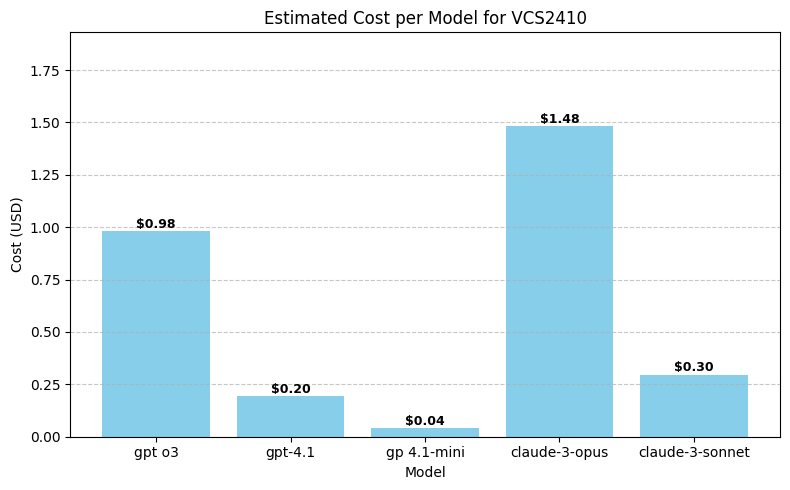

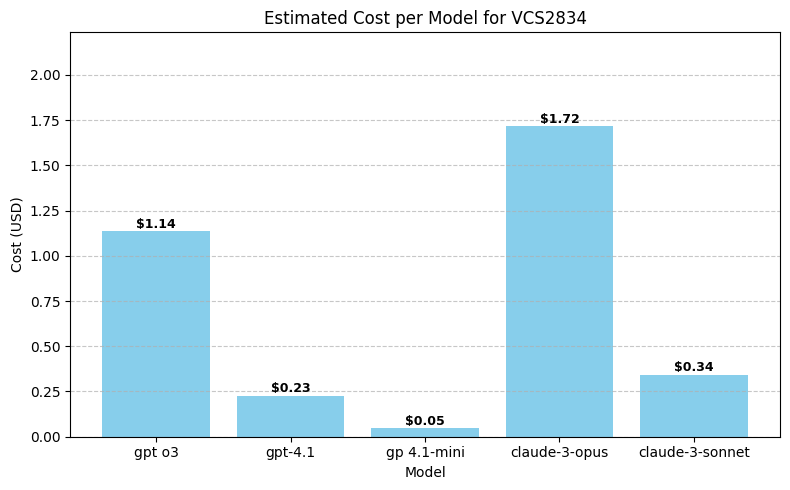

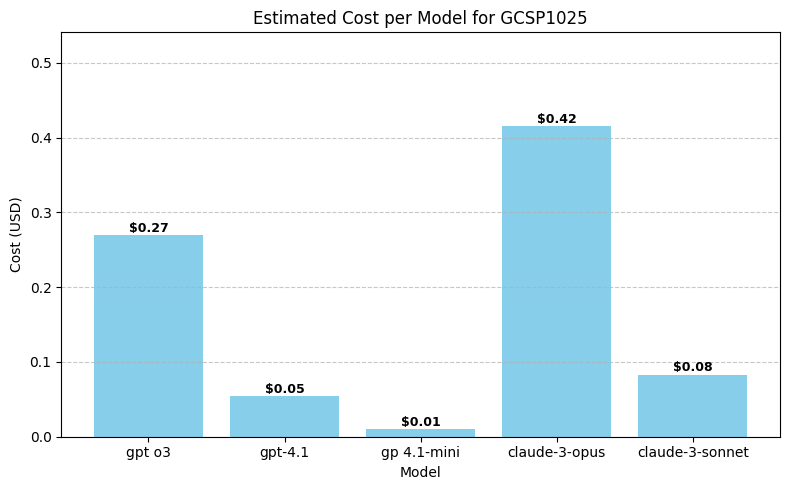

In [5]:
import tiktoken
import matplotlib.pyplot as plt



expected_output_tokens = 800  # You can adjust this if needed

# === Pricing Table (as of May 2025) ===
pricing = { 
        "gpt o3": {"input": 10.0, "output": 40.0},
        "gpt-4.1": {"input": 2.0, "output": 8.0},
        "gp 4.1-mini": {"input": 0.4, "output": 1.6},
        "claude-3-opus": {"input": 15.0, "output": 75.0},
        "claude-3-sonnet": {"input": 3.0, "output": 15.0},
    }


# Store data for plotting
plot_data = {}

encoding = tiktoken.get_encoding("cl100k_base")

# Process each document and model
for text_name, input_text in project_dict.items():
    plot_data[text_name] = {}
    input_tokens = encoding.encode(input_text)
    num_input_tokens = len(input_tokens)

    for model in pricing.keys():
        price_per_1k = pricing[model]
        cost_input = (num_input_tokens / 1_000_000) * price_per_1k["input"]
        cost_output = (expected_output_tokens / 1_000_000) * price_per_1k["output"]
        total_cost = cost_input + cost_output
        plot_data[text_name][model] = total_cost

# Plotting with value annotations
for text_name, costs in plot_data.items():
    models_list = list(costs.keys())
    cost_values = list(costs.values())

    plt.figure(figsize=(8, 5))
    bars = plt.bar(models_list, cost_values, color='skyblue')
    plt.title(f"Estimated Cost per Model for {text_name}")
    plt.ylabel("Cost (USD)")
    plt.xlabel("Model")
    plt.ylim(0, max(cost_values) * 1.3)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add cost annotations on top of bars
    for bar, cost in zip(bars, cost_values):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.0002, f"${cost:.2f}",
                 ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()


# 2. Using LLM API analyse PDFs

Excercises:

1. System Prompt: Play with the system prompt.
2. Use different values for temperature (0-1). What do you observe?


In [7]:

# === Function to get the answer from the model ===
client = openai.OpenAI(api_key=openai_key)

user_prompt = "What color is the sky?"

# TODO 1: Play around with different system prompts. Use the proposed prompts or  - how does it change the output?
system_prompt = "You are a helpful assistant. Answer the question directly."
#system_prompt = "You are a poet. Don't answer the question directly, but answer in vague poems."
#system_prompt = "You are a extremely accurate researcher. Answer the question and cover all caveats."“#
#system_prompt = "You are a Swiss German translator. Translate all inputs to Swiss German without adding content."

# TODO 2: Play around with different temperatures. Use a more creative system prompt (e.g. the poet one). How does it change the output?
temperature_value = 0.0



messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_prompt}
 
                        ]


MODEL = "gpt-4"  # Choose the model you want to use
response = client.beta.chat.completions.parse(
                        model=MODEL,
                        messages= messages,
                        temperature=temperature_value,
                        max_tokens=1000,
                        )
output = response.choices[0].message.content

print(output)

In the realm where dreams take flight,
It's a canvas kissed by light.
A dance of hues, both old and new,
From dawn's soft blush to twilight's blue.

At times it weeps in shades of gray,
A somber cloak that shrouds the day.
Yet often, in its vast expanse,
It sparkles in the sun's romance.

A mirror of the soul's desires,
It burns with sunset's crimson fires.
And in the hush of night, behold,
A tapestry of stars, untold.

So, what color could it be?
It's every shade the heart can see.


## 3. Get structured information from PDFs without structured output

Our main goal is obtaining structured information from unstructured text. Here we use carbon projects, to extract the companies that are involved in developing them.

Excercise: write a user prompt that tells the model what to do. Also go through the category description to get a feeling how to write a codebook in a prompt.

In [8]:
User_prompt =  """ 
TODO: Fill user prompt here and run model in the cell below
"""

  

# Do not change this - TODO: go over codebook to see an example for a prompt
category_description ="""
  <categories>

  <category1>
  actor_name: The name of the actor is the legal name of the entity. Stakeholders only mentioned as consulted stakeholders in Stakeholder Consultation (e.g. "village of Rishabbdeo") are no actors, since they have no active role in the project. However, organisations conducting stakeholder consultations are actors. 
  Actors must be concrete organisations or a organised group of people (company, cooperative, NGO,...) and not a unorganised group of people (Field Agents/Production Managers/Farmers/Local NGOs).
  <examples>
    -Company prepares PDD (indicated by prepared by...)
    -Company is resoponsible of Operaitons
    -Company is responsible for selling carbon credits
    -Company is responsible for technology provision
    -Company is responsible for project development
    -Company is responsible for project implementation
    -Company is responsible for project management
    -Company has any other active role in the project


  <category2>
  role: Each actor has at least one role in the project. We distinguish between the following roles in the carbon credit value chain. Make absolutely sure to only use role names listed here and do not use any other names:
    - "Primary Sales"
    - "Carbon Services"
    - "Technology Provision"
    - "Operation"
    - "Registry & Standard"
    - "Validation & Verification"
    - "Land Steward/land owner"
    - "Purchaser/Funder"
    - "Research partners"
    - "Other" 
    The roles are defined as:

  <role1>
  1. Primary Sales:
        The entity that holds the original ownership of the carbon credits generated by a project.
        Primary Sales does not refer to the sale of other products or benefits from the project (e.g., timber, crops). It includes:
            - The project proponent or project owner.
            - The landowner or entity responsible for the project's operations if they hold the carbon rights.
            - An entity explicitly responsible for selling the carbon credits, even if carbon rights are not formally detailed in the document.

        Key Indicators: 
            - The entity is contractually assigned the carbon rights.
            - The entity is described as the legal owner of the project's Verified Emission Reductions (e.g., CERs, VERs).

        Notes:
            -Focus on carbon credit ownership and sales only, not broader project product sales.
      <examples>
      <example1>
          -"All the revenue from the usufructs of trees planted will belong to the communities. Only the carbon rights will belong to the VPA Implementer/CME, from which revenues will be generated to implement the project. [....] company A as the CME and company B
           as the Project Implementer are involved in the project activity. [...] The GS VERs from the trees are with CME, OffsetFarm Pte. Ltd. This is transferred through end user agreements to the CME/VPA Implementer." -> actor_name="company A", role="Primary Sales"
      </example1>
      <example2>
          -"The Project Proponent is company a, as stated in the PD, represented by Carter Coleman and Theron Morgan-Brown. [...] The Lease/Carbon Rights contracts, signed by the District, Village Council and Individual landowners give copmany a the right to produce and sell carbon credits, and the CCROs assure the long-term security of the owner." -> actor_name="company A", role="Primary Sales"
      </example2>
      <example3>
          -"Subsequently, company A has a contractual agreement with the lead project proponent company B transferring the carbon rights of the project to company B. This project development and project ownership agreement between company A and company B clearly states, that the lead project developer company b is the legal owner of the project and of its Verified Emission Reductions “VERs” under this cooperation throughout the agreement," -> actor_name="company B", role="Primary Sales"
      </example3>
  </role1>

  <role2>
  2. Carbon Services: 
    Services provided by entities to support the development and management of carbon credit projects. Activites include:

    1. Pre-Project Assistance:
        -Project identification
        - Preparation of Project Design Documents (PDD)
        - Feasibility studies related to carbon potential
        - Environmental Impact Assessments

    2. Methodology Know-How:    
        - Development of carbon methodologies
        - Baseline scenario development

    3. Registration & Monitoring Design:
        - Due diligence for project registration
        - MRV (Monitoring, Reporting, and Verification) system design
        - Assigning registration and issuance tasks
        - Aggregating monitoring data to meet standard requirements
        - Developing monitoring plans
        - Coordination with carbon registries and standards bodies

    4. Commercial Know-How related to carbon credits:
        - Commercial advisory services
        - Structuring of Emission Reduction Purchase Agreements (ERPAs)

    5. Consultance on carbon credit project development.
        - Consulting services on any aspect of carbon credit project development if related to the above activities (e.g. technical advisor, strategic consultant...)


    Notes:
        - Field data collection is classified under Operation, not Carbon Services. However, aggregation of field data for preparing reports for the standard, registry or validator is a Carbon Service.
        - Verification and validation of project documents are not considered Carbon Services.
        - Technical support, advising, consulting, or assistance is only counted as Carbon Service if it directly relates to activities around carbon credit development (as listed above), not if relates to Operation acitivities.
        - It is not Carbon Service if it relates to on-the-ground project activities, training of participants, or project operations.

        Preparing a Carbon Project Description document is considered a Carbon Service activity. The company or entity that prepared the description is classified as a Carbon Service provider.

      <examples>
      <example1>
          -"specialized services on climate change mitigation. Key services offered by company A include consulting to governments, non governmental organizations, and private comp anies in several areas related to the environment and climate change. Company A is involved with the design and development of climate
          change mitigation projects and undertakes related services such as performing project baseline studies, designing and implementing monitoring plans and identification of project developers and sources of funding for projects." -> actor_name="Copmany A", role="Carbon Services"
      </example1>
      <example2>
          - "Organization name Company A Role in the project Project Proponent; VCS technical advisor and project partner responsible for VCS project development" -> actor_name="Company A", role="Carbon Services"
          The Hongera Reforestation Project (Mt Kenya and Aberdares) is a reforestation and afforestation initiative designed and funded by Company A , with technical support from Company B, and implemented by Company C. -> actor_name="Company B", role="Carbon Services", Explanation: Technical support in project descriptions usually referes to carbon services
      <example3>
          - "Document Prepared by company A " -> actor_name="company A", role="Carbon Services". Explanation: Preparing the project description document is a carbon servce
      </example3>
      <example4>
          - "company A is the CME of the project" -> actor_name="Company A", role="Carbon Services". Explanation: The Coordinating/Managing Entity (CME) is responsible for project development and carbon services under Gold Standard
      </exmaple5>
      </examples>
  </role2>

  <role3>
  3. Technology Provision: 
       Supplying or developing technology that supports project activities. Includes activities such as:
        - Developing or providing Original Equipment Manufacturer (OEM) technologies (e.g. biochar kiln, monitoring equipment, other machinery)
        - Creating or supplying digital Monitoring, Reporting, and Verification (dMRV) applications or systems
        - Providing technologies designed to incentivize participant engagement
        - Other technological solutions relavant to the project development or operation

        Notes:
        - Technology Provision is recognized when the project actively uses the technology provided or developed by the actor.
        - Merely using or maintaining a dMRV system does not qualify as Technology Provision if the system was developed by another organization.

      Provide technology for projects (e.g. OEMs, developers of dMRV app/technology, technologies to incentivise participation). We consider it as activ project participation if the project uses the technology provided or developed by an actor. Usage or maintanance dMRV systems in project is not technology provision if the system is developed by other organisation.
      <examples>
      <example1>
          -"Internal documentation and logged into the VarunaCarbon dMRV system developed by company A" -> actor_name="company A", role="Technology Provision"
      </example1>
      <example2>
          -"Benefits include a livestock-to-market mechanism provided by our commercial partner companz A. The MNP organizes mobile auctions that bring rural farmers and commercial buyers together; provides livestock management training for herders, NGOs, and farmers; and organizes mobile abattoirs, enabling increased market opportunities for farmers and providing NGOs and farming communities with bulk purchasing power and access to critical farming equipment and vaccinations." -> actor_name="Company A", role="Technology Provision"
      </example2>
      </examples>
  </role3>

  <role4>
  4. Operation: 
        Involves managing, conducting, or coordinating activities directly on the ground related to carbon project execution. Operation is also often referred to as Implementation. Includes tasks such as:
            - Local contracting
            - Resource management
            - Hiring and managing local personnel
            - Communication and coordination with project participants and local stakeholders
            - Conducting participant training related to project activities
            - On-the-ground data collection for monitoring purposes
            - Organizing, supervising and executing project activities (e.g., logging, planting)
            - Operating nurseries for seedling production
            - Agricultural or timber value chain activities that are part of the project or directly linked to the project (e.g., training local community members, land management, agricultural/forestry practices)

        Notes:
            - Field data collection for Monitorin, Reporting and Verification (MRV) is Operation. However, setting up the MRV plan is a Carbon Service. Companies that provide a digital MRV system are considered Technology Provision.
            - Technical support activities are considered Operation if they involve implementation or project execution (e.g., training local community members, land management, agricultural/forestry practices). If they are related to carbon services (e.g., methodology development, baseline development, MRV design, Project Description Design), they are considered Carbon Services.
            - Operation is understood as an ongoing process. Single studies or reports for example on local communities or stakeholders that are comissioned by the project are not considered Operation, but Research Partners.
           


      <examples>
      <example1>
          -"The Hongera Reforestation Project (Mt Kenya and Aberdares) is a reforestation and afforestation initiative designed and funded by company A, with technical support from company B , and implemented by copmany C." -> actor_name="copmany C", role="Operation" . Explanation: Implementation of projects is an operational role
      </example1>
      <example2>
          -"company A, and raised to viable seedling or sapling planting age (which is species-dependent) in nurseries established by company A or the project." -> actor_name="Company A", role="Operation". Explanation: Planting trees is an operational role
      </example2>
      <example3>
          -"These activities will be conducted by local company A members, who are trained by company B technical specialists, supported by the copmany C team and Copmany D advisors." -> actor_name="company B", role="Operation". Explanation: Training of local community members is an operational role
      </example3>
      <example4>
          -"company A is the VPA implementer." -> actor_name="Company A", role="Operation". Explanation: Voluntary program of activity (VPA) implementer is the local implementer of Gold Standard projects.
      </examples>
  </role4>

  <role5>
  5. Registry & Standard: 
    The organization or system under which a carbon project is registered and certified.

    Common Standards:
        - Verified Carbon Standard (VCS)
        - Gold Standard
        - Carbon Standards International
        - Plan Vivo 
        - Puro
        - Isometric

    Notes:
        - If a standard or registry other than those listed above is referenced, confirm carefully that it is indeed acting as a Registry or Standard before assigning this role.
        - Focus only on entities responsible for certifying, issuing, or overseeing carbon credit registration and verification.
      <examples>
      <example1>
          -"Carbon Registry: registry A" -> actor_name="registry A", role="Registry & Standard"
      </example1>
      </examples>
  </role5>

  <role6>
  6. Validation & Verification: 
      -Validation & Verification Bodies. These are always third party organisations that are not involved in the project otherwise 
      <examples>
      <example1>
          -"company A has validated that the project Udzungwa Corridor Reforestation is in compliance with the Verified Carbon Standard version 4 and the CCB Standards" -> actor_name="copmany A", role="Validation & Verification". Reason: AENOR is a validated project against standard
      </example1>
      <example2>
         -"Validation Body Company A 2000 Powell Street, Ste. 600 Emeryville CA 94608 USA www.SCSglobalServices.com" -> actor_name="Company A", role="Validation & Verification"
      </example2>
      </examples>
  </role6>


  <role7>
  7. Land Steward/land owner: 
    - The entity that owns, manages, or holds responsibility for the land on which the project is implemented.
    - This can include ownership with or without a direct economic interest in the land.
   

    Includes:
        - Ministries or government agencies
        - Conservation NGOs
        - Private companies
        - Any entity holding land titles or responsible for distributing land titles

    Notes: 
        - Entities that own the land are always assigned the Land Steward/Land Owner role, regardless of their level of economic involvement.
        - Stewardship can involve either direct land ownership or administrative control over land title distribution.
        - Being the entity that leases land from a landonwer does not qualify as landonwer or land steward
      <example1>
          -"Company A Region Non-Profit Company (K2C) is the implementing agency managing the 2,474,700 ha (UNESCO) Kruger to Canyons biosphere reserve since 2001. K2C is currently running 12 projects with partners in the biosphere linking sustainable development and biodiversity conservation including expansion of protected areas and sustainable land management" -> actor_name="Company A", role="Land Steward"
      </example1>
      </examples>
  </role7>

  <role8>
  8. Purchaser/Funder: 
    Entities that commit funding or financial support to carbon projects. It includes:
       - Grant funding
       - Loans
       - Long-term offtake agreements (e.g., future purchase of carbon credits)
       - Direct investment into the project
       - Initial financing of project equipment
       - Internal funding or financing of equipment by project participants

    Notes:
       - If funding is provided through a subsidiary, the parent company is recorded as the Purchaser/Funder.
       - Focus on entities providing financial resources that enable project development or operation, not just buyers of final carbon credits unless it is through long-term financial commitments.

    
      <examples>
      <example1>
          -"company A’s audit team accessed the three VERPAs (Verified Emission Reductions Purchase Agreements) signed with the following off-takers:
              - company B .
              - company C.
              - company D ." -> actor_name="Company B", role="Purchaser/Funder"; actor_name="Company C", role="Purchaser/Funder; "Company D", role="Purchaser/Funder
      </example1>
      <example2>
          -"company A is a co-funder to CSA for the Pro-Nature Enterprises Project" -> actor_name="Company A", role="Purchaser/Funder"
      </example2>
        <example3>
            -"Company A is an investor in the project" -> actor_name="Company E", role="Purchaser/Funder"
        </example3>
        <example4>
            -"The project equipment is financed by company F" -> actor_name="Company F", role="Purchaser/Funder"
        </example4>
      </examples>
  </role8>

  <role9>
  9. Research partners: 
      Research institutions, universities, or NGOs that conduct research or provide studies directly for the project that are not primarily related to carbon credit development or carbon credit methodologies.
      Includes:
        - Conducting feasibility studies or environmental/social impact studies that are important for the project’s development but not tied to carbon credit methodologies.
        - Providing baseline studies that focus on non-carbon-related aspects (e.g., biodiversity studies, socio-economic assessments).
        - General scientific or technical research aimed at understanding or supporting the project context, but not specific to carbon measurement or crediting.
        - Social assessments, community impact studies, or other research that informs project design or implementation but does not focus on carbon credit methodologies.

      Excludes:
        - Carbon-related studies such as modeling carbon stocks, carbon sequestration estimation, or developing carbon methodologies, which are part of Carbon Services.
        - If the research is primarily focused on developing or supporting carbon credit methodologies (e.g., GHG emissions modeling), this falls under Carbon Services, not Research Partners.
        
      Notes:
      - Research Partners are only considered actors if they conduct studies specifically commissioned for the project.
      - If an organization is cited for their published research in a general sense but is not directly involved in the project, they are not considered a Research Partner.

      <examples>
      <example1>       
          "The project proponent issued as study with university A on the social implications of the project" -> actor_name="university A", role="Research partners"
      </example1>
       
      </examples>
  </role9>

  <role10>
  10. Other:
   Definition:
    This role is for entities whose involvement in the project does not clearly fit into any of the previously defined roles. It serves as a catch-all category for undefined or unclear roles that do not directly relate to project implementation or carbon services. Onlyuse this category if the actor does not fit any other category. It includes:
     - Entities providing general consulting or approval for the project (e.g., a government agency providing oversight but not actively engaged in project implementation).
     - Entities involved in community engagement activities not explicitly tied to training for project implementation (if not directly involved in training, this would fall under Operation).
     - Entities providing legal advice
    
    Excludes:
    - If an entity is already categorized under one of the other roles (e.g., Land Steward, Carbon Services, Operation), do not add "Other" as an additional role for the same entity.
    - Roles that are directly related to carbon credit generation or project operations (those should be categorized appropriately under Carbon Services, Operation, etc.).

    Notes:
    - It serves as a miscellaneous category, but should not be overused when an entity clearly fits within another role.
    
    <examples>
      <example1>       
          "Government agency A providing consultation or approval for the project without having a defined role in implementation." -> actor_name="Government Agency A A", role="Other"
      </example1>
       
      </examples>


  </role10>
  </category2>

  <category3>
  activities: 
      Concrete actions that the actor is taking in the project. Activities must be named for an oragnisation in the project description. Concrete acitivites relate to project roles.
      <examples>
      <example1>
          -"These two villages are the ones that have already reached agreements with company A, whereas Idunda and Kidete have not yet joined the carbon project (this is a grouped project)." -> actor_name="company A", activities=["Reached agreements with villages"]
      </example1>
      <example2>
          -"The company A is responsible for the planting of trees, thinning, and pruning" -> actor_name="Copmany A", activities=["Planting trees", "Thinning", "Pruning"]
      </example2>
       <example3>
            "NGO B engaged with local communities to work out a benefit sharing plan" -> actor_name="universityz A", role="Research partners"
        </example3>
      </examples>
  </category3>

  <category4>
  headquarter: 
      Headquarter of the actor. This can be a city, country or region. Be as granular as possible while sticking to given information.
      <examples>
      <example1>
          -"As stated in the PD, Udzungwa Corridor Limited is a registered company in Tanzania, No. 151884695 /259/, with a Board of Directors." -> headquarter="Tanzania"
      </example1>
      <example2>
          -"Organization name
              Company A
              Role in the project
              Property Manager
              Contact person
              Alvaro Perez del Castillo
              Title
              General Manager
              Address
              Costa Rica 1566 , Montevideo
              Telephone
              +598 95630638
              Email
              alvaro.perez@pike.com.uy" -> headquarter="Montevideo, Uruguay"
      </example2>
      </examples>
  </category4>
  
  </categories>
  """
system_prompt = "You are a research assistant. Base all your answers on information carbon project descriptions. Do not add any information that is not in the project description. If you are not sure, write 'Not found'."


In [10]:
# We are using the first 200000 characters of the project description to reduce costs for the sake of the workshop
full_prompt = system_prompt + category_description + f" The carbon project description starts here: \n {VCS2410[0:200000]}"

system_prompt = "You are a research assistant. Base all your answers on information carbon project descriptions. Do not add any information that is not in the project description. If you are not sure, write 'Not found'."

messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": full_prompt}
    
                        ]


MODEL = "gpt-4.1-2025-04-14"  # Choose the model you want to use
response = client.beta.chat.completions.parse(
                        model=MODEL,
                        messages= messages,
                        temperature=0,
                        max_tokens=10000,
                        )

output = response.choices[0].message.content

print(output)

{
  "actors": [
    {
      "actor_name": "Miro Forestry Developments Ltd.",
      "role": "Primary Sales",
      "activities": [
        "Project owner and project proponent",
        "Performs top level management of the project",
        "Takes main decisions regarding financial, design, management and market elements",
        "Main communication channel with the project developer (South Pole) and the VCS standard"
      ],
      "headquarter": "London, United Kingdom"
    },
    {
      "actor_name": "Miro Forestry Developments Ltd.",
      "role": "Operation",
      "activities": [
        "Project owner and project proponent",
        "Performs top level management of the project",
        "Takes main decisions regarding financial, design, management and market elements",
        "Main communication channel with the project developer (South Pole) and the VCS standard"
      ],
      "headquarter": "London, United Kingdom"
    },
    {
      "actor_name": "Miro Forestry (Ghana) L

## Possible Solution for User Prompt

In [9]:
# Possible solution for last excercise - Example user prompt:
user_prompt =  """ 
<objective>
  Extract structured information about project actors involved in carbon projects based on the unstructured project descriptions. Follow the guidelines strictly and ensure outputs adhere to the provided schema.
  </objective>
  <instructions>
  You are tasked with extracting structured information about project actors involved in carbon projects based on the project descriptions. Follow the guidelines strictly and ensure outputs adhere to the provided schema.
  Only use information explicitly stated in the project description. If information are not clearly linked to the project or entities write 'Not found'. If entitites are mentioned but are not involved in the project, skip them.

  Project Actors are entities or organisations involved in the project. They can be for-profit companies, non-profit organizations, governments, research institutions, NGOs, cooperatives, etc. Each actor can have multiple roles in the project.  They need to have an active role, and are not only listed as a stakeholder in the project. 

  Company names in the prompt examples are annonimized to company A, B, C, D... so you understand the context, but the information from the task description do not leak into the ouput.
  </instructions>
  
"""

# 4. Adding structured output

Now we add a output schema to the LLM instruction. This enables us to read model output to dataframe.

Excercise: read output structure and understand how output is transformed into a dataframe

In [11]:
output_structure = """ 

\n 

Please strictly follow this json output structure - don't add any other information or text to your output:

{
"actors": [
        {
            "actor_name": "example actor",
            "activities": ["Activity 1", "Activity 2"],
            "role": ["role A", "role B"],
            "headquarter": "Location",
        }
    ]
}
"""


In [13]:
full_prompt = user_prompt + category_description + f" The carbon project description starts here: \n {VCS2410[0:200000]}" + output_structure
system_prompt = "You are a research assistant. Base all your answers on information carbon project descriptions. Do not add any information that is not in the project description. If you are not sure, write 'Not found'."

messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": full_prompt}
    
                        ]


MODEL = "gpt-4.1-2025-04-14"  # Choose the model you want to use
response = client.beta.chat.completions.parse(
                        model=MODEL,
                        messages= messages,
                        temperature=0,
                        max_tokens=10000,
                        )

# Read LLM output
output = response.choices[0].message.content

# Extract the JSON part from the output
cleaned_output = output.strip("```json").strip("```").strip()
data = json.loads(cleaned_output)

df_actors=pd.json_normalize(data['actors'])


df_actors

,actor_name,activities,role,headquarter
0,Miro Forestry Developments Ltd.,"[Project owner and project proponent, Performs...","[Primary Sales, Operation]","London, United Kingdom"
1,Miro Forestry (Ghana) Ltd.,"[Local operator of the project, All operations...",[Operation],Ghana
2,Swiss Carbon Value Ltd.,"[Project developer, Advising in compliance wit...",[Carbon Services],"Zurich, Switzerland"
3,Forestry Commission of Ghana,"[Mandated custodian of the reserve lands, Entr...",[Land Steward/land owner],Ghana
4,South Pole,"[Prepares project documents, Advises in compli...",[Carbon Services],Not found
5,Forestry Research Institute of Ghana (FORIG),[Collaborates with the project to establish sa...,[Research partners],Ghana


# 5. Run for different projects

Run the box below try to understand how to add the output of different documents and LLM API requests to one dataframe

In [14]:
# Define the 
df_actors = pd.DataFrame(columns=['project_id', 'actor_name', 'activities', 'role', 'headquarter'])

for project in project_dict.keys():
    print('Processing project :', project)
    project_text = project_dict[project]
    user_prompt = system_prompt + category_description + f" The carbon project description starts here: \n {project_text}" + output_structure
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    MODEL = "gpt-4.1-2025-04-14"  # Choose the model you want to use
    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=messages,
        temperature=0,
        max_tokens=10000,
    )

    output = response.choices[0].message.content

    cleaned_output = output.strip("```json").strip("```").strip()

    data = json.loads(cleaned_output)

    df_output=pd.json_normalize(data['actors'])
    df_output['project_id'] = project  # Add project ID to the DataFrame

    df_actors = pd.concat([df_actors, df_output], ignore_index=True)

df_actors

In [15]:
df_actors

,project_id,actor_name,activities,role,headquarter
0,VCS2410,Miro Forestry Developments Ltd.,"[Project owner and project proponent, Performs...","[Primary Sales, Operation]","London, United Kingdom"
1,VCS2410,Miro Forestry (Ghana) Ltd.,"[Local operator of the project, All operations...",[Operation],Ghana
2,VCS2410,Swiss Carbon Value Ltd.,"[Project developer, Project partner for advisi...",[Carbon Services],"Zurich, Switzerland"
3,VCS2410,South Pole,[Develops the project documents required for o...,[Carbon Services],Not found
4,VCS2410,Forestry Commission of Ghana,"[Mandated custodian of the reserve lands, Entr...",[Land Steward/land owner],Ghana
5,VCS2410,"Traditional Council (through its President, th...","[Allodial owner of the land, Leases land to Mi...",[Land Steward/land owner],Ghana
6,VCS2410,Kumawu and Mampong Forestry District Office,[Manages the reserves land on behalf of the pe...,[Land Steward/land owner],Ghana
7,VCS2410,Winniwood Consulting,[Conducted Environmental and Social Impact Ass...,[Research partners],Not found
8,VCS2410,SAL Consult,[Tasked with identifying High Conservation Val...,[Research partners],Not found
9,VCS2834,WeForest,[Project proponent for validation under VCS an...,"[Primary Sales, Carbon Services]","Brussels, Belgium"


# 6. Extract and process images from Project Description

As seen in the task before, for some tasks, important information can hide in images. If we only read text, we might loose these information. Here is the code on how to integrate images in the prompt.

Note: Here we read two images that are saved in in the project folder. The pipeline to get to those two images (not detailed here) was:
1. Read all images from the pdf (using python package fitz)
2. Classify each image in "relavant" or "irrelevant" with low cost LLM (gpt-4.1 mini) to reduce overall project costs and don't exceed context window limits - most images in project descriptions are irrelevant for our research question.
3. Save images locally 

If you are interested in this part of the pipeline, feel free to approach me. I am happy to tell you more about it or share code snippets.

In [16]:
pdf_file = "reports/GCSP1025.pdf"


import fitz  # PyMuPDF
import base64
import io
from PIL import Image
import pandas as pd
import json
client = openai.OpenAI(api_key=openai_key)


pdf_file = "reports/GCSP1025.pdf"

# Extract images from PDF
def load_images_from_folder(folder_path):
    image_entries = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            with open(os.path.join(folder_path, filename), "rb") as img_file:
                encoded_string = base64.b64encode(img_file.read()).decode("utf-8")
                image_entries.append({
                    "image_base64": encoded_string,
                    "filename": filename
                })
    return image_entries

# Example input values
project_id = "GCSP1025"
image_folder = f"reports/{project_id}_relevant_images"
images = load_images_from_folder(image_folder)




for project in ['GCSP1025']:
    project_text = project_dict[project]
    user_prompt = system_prompt + category_description + f" The carbon project description starts here: \n {project_text}" + "Also consider the information from the images. "+ output_structure

    # Prepare message with image(s)
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]

    # If images should be included as separate messages
    for img in images:
        messages.append({
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{img['image_base64']}"
                    }
                }
            ]
        })

    MODEL = "gpt-4.1-2025-04-14"
    response =  client.beta.chat.completions.parse(
        model=MODEL,
        messages=messages,
        temperature=0,
        max_tokens=10000,
    )

    output = response.choices[0].message.content
    cleaned_output = output.strip("```json").strip("```").strip()
    data = json.loads(cleaned_output)

    df_output = pd.json_normalize(data['actors'])



In [21]:
df_output

,actor_name,activities,role,headquarter
0,Carboneers United B.V.,"[Registration of the project, Contact with all...","[Primary Sales, Carbon Services, Operation]",Not found
1,Beyond Karbon,"[Providing farmer and women groups, Providing ...",[Operation],Not found
2,MEDA,"[Providing women groups, Providing a field man...",[Operation],Canada
3,PlantVillage (The Pennsylvania State University),[Development and provision of PlantVillage mob...,[Technology Provision],"Pennsylvania, USA"
4,High Plains Biochar,"[Provision of pyrolysis equipment, Partnership...",[Technology Provision],Not found
5,Carbon Standards International,"[Certification of C-Sink Manager, Registration...",[Registry & Standard],Not found
6,CERES,[On site audit],[Validation & Verification],Not found
7,Terraspect,[Last mile payments],[Other],Not found
